# Collecting experiments data in a data frame

### Bogumił Kamiński

In [1]:
] activate .

  Activating project at `C:\Users\roell\Julia Coding\2 - DataFrames`


In [2]:
using DataFrames

In [3]:
using Statistics

In [9]:
using Pkg
ENV["PYTHON"]=""
Pkg.build("PyCall")

using PyPlot

    Building Conda ─→ `C:\Users\roell\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\b19db3927f0db4151cb86d073689f2428e524576\build.log`
    Building PyCall → `C:\Users\roell\.julia\scratchspaces\44cfe95a-1eb2-52ea-b672-e2afdf69b78f\9816a3826b0ebf49ab4926e2b18842ad8b5c8f04\build.log`


<div class="alert alert-block alert-info">
    <p><b>PyPlot.jl configuration:</b></p>
    <p>In some environments automatic installation of PyPlot.jl might fail. If you encounter this ussue please refer to <a href="https://github.com/JuliaPy/PyPlot.jl#installation">the PyPlot.jl installation instructions</a>. </p>
</div>

In particular typically executing the following commands:

```
using Pkg
ENV["PYTHON"]=""
Pkg.build("PyCall")
```

should resolve the PyPlot.jl installation issues. However, on OS X sometimes more configuration steps are required. You can find the detailed instructions [here](https://github.com/JuliaPy/PyPlot.jl#os-x).

In [11]:
using Random

In [13]:
using Pipe

In this part we will run a simple Monte Carlo simulation so show examples how one can work with data frames.

Consider the following puzzle.

We draw independent random numbers from $U(0,1)$ distribution. On the average, how many draws do we need, till the sum of these numbers exceeds $1$?

Here is the code that runs this experiment once. For tutorial reasons we keep all the generated random numbers and recalculate their sum in each iteration (you can try to improve the efficiency of this code as an exercise).

In [15]:
# how many draws until cumulative sum exceeds 1

function sim_e()
    draw = Float64[] # we draw a float between 0 and 1
    while true
        push!(draw, rand()) #draw a random number
        sum(draw) > 1.0 && return draw # add it to draw vector, if it exceeds 1, I return this vector 
    end
end

sim_e (generic function with 1 method)

In [17]:
Random.seed!(1234); # just to make sure we get the same results if we are on the same version of Julia

Let us run our simulation several times:

In [19]:
res = [sim_e() for _ in 1:5]

5-element Vector{Vector{Float64}}:
 [0.32597672886359486, 0.5490511363155669, 0.21858665481883066]
 [0.8942454282009883, 0.35311164439921205]
 [0.39425536741585077, 0.9531246272848422]
 [0.7955469475347194, 0.4942498668904206]
 [0.7484150218874741, 0.5782319465613976]

and check that each time we finished just when we exceeded $1$:

In [21]:
sum.(res) # check the sums

5-element Vector{Float64}:
 1.0936145199979923
 1.2473570726002003
 1.347379994700693
 1.2897968144251402
 1.3266469684488718

In [23]:
@. sum(res) - last(res) # let's remove the last value of each vector and we verify it is smaller than 1

5-element Vector{Float64}:
 0.8750278651791616
 0.8942454282009883
 0.3942553674158509
 0.7955469475347196
 0.7484150218874741

All looks good so far! (and as a bonus we have just made a small exercise in broadcasting)

Now let us populate a data frame with the results of our experiments

In [25]:
df = DataFrame() # let's create an empty dataframe

@time for i in 1:10^7 #do the experiment 10 million times
    push!(df, (id=i, pos=sim_e())) #experiement number in id column and the results into the pos column
end

 59.277037 seconds (120.38 M allocations: 4.015 GiB, 50.57% gc time, 3.29% compilation time)


As you can see the process was quite fast, `push!`-ing data to a `DataFrame` is efficient.

In [27]:
df #easy to store any type of data in a data cell

Row,id,pos
,Int64,Array…
1,1,"[0.727935, 0.00744801, 0.199377, 0.439243]"
2,2,"[0.682533, 0.956741]"
3,3,"[0.647855, 0.996665]"
4,4,"[0.749194, 0.110084, 0.491383]"
5,5,"[0.565145, 0.253812, 0.626794]"
6,6,"[0.234105, 0.124792, 0.609875, 0.672793]"
7,7,"[0.761916, 0.588872]"
8,8,"[0.365854, 0.131026, 0.946453]"
9,9,"[0.574323, 0.67765]"


Let us count the number of jumps we have made in each step using the `transform!` function:

In [29]:
transform!(df, :pos => ByRow(length) => :jumps)
# let's add a new column which represents the number of jumps
# transform bank check's the length of pos column for each row and stores it in the jumps

Row,id,pos,jumps
,Int64,Array…,Int64
1,1,"[0.727935, 0.00744801, 0.199377, 0.439243]",4
2,2,"[0.682533, 0.956741]",2
3,3,"[0.647855, 0.996665]",2
4,4,"[0.749194, 0.110084, 0.491383]",3
5,5,"[0.565145, 0.253812, 0.626794]",3
6,6,"[0.234105, 0.124792, 0.609875, 0.672793]",4
7,7,"[0.761916, 0.588872]",2
8,8,"[0.365854, 0.131026, 0.946453]",3
9,9,"[0.574323, 0.67765]",2


Let us dissect what we have written above:
* `transform!` adds columns to a data frame in-place
* `:pos` is a source column
* `ByRow(length)` tells us that we want to apply `length` function to each element for `:pos` column (without it `length` would be applied to the whole column - can you guess what would be the result?)
* `:jumps` is the name of the column that should be created

Now we are ready to find the average number of jumps that are made:

In [31]:
mean(df.jumps) #let's look at the mean of jumps

2.7183826

or

In [33]:
combine(df, :jumps => mean) #we could have also used the combine function

Row,jumps_mean
,Float64
1,2.71838


which happens to be very close to:

In [35]:
MathConstants.e

ℯ = 2.7182818284590...

Let us now find a distribution of number of jumps:

In [37]:
jumps_agg = @pipe df |> 
                  groupby(_, :jumps, sort=true) |> #group it by jumps, sort from increasing to decreasing
                  combine(_, :jumps => length) # take the length of the jumps vector

Row,jumps,jumps_length
,Int64,Int64
1,2,5000265
2,3,3332702
3,4,1249879
4,5,333412
5,6,69869
6,7,11866
7,8,1754
8,9,227
9,10,23


and normalize it as a fraction (and at the same time calculate some theoretical result that we have *guessed* :)):

In [41]:
transform!(jumps_agg, #let's take the jumps aggregated
           :jumps_length => (x -> x ./ sum(x)) => :simulation, #number of elements that had this numer of jumps and we calcualte the %
           :jumps => ByRow(x -> (x-1) / factorial(x)) => :theory) #Put a theoretical value 

Row,jumps,jumps_length,simulation,theory
,Int64,Int64,Float64,Float64
1,2,5000265,0.500027,0.5
2,3,3332702,0.33327,0.333333
3,4,1249879,0.124988,0.125
4,5,333412,0.0333412,0.0333333
5,6,69869,0.0069869,0.00694444
6,7,11866,0.0011866,0.00119048
7,8,1754,0.0001754,0.000173611
8,9,227,2.27e-5,2.20459e-5
9,10,23,2.3e-6,2.48016e-6


Let us briefly justify how we have guessed it (you can safely skip the derivation):

Formula
$$
p_n = \frac{n-1}{n!}
$$

$$
\sum_{n=2}^{+\infty}p_n=\sum_{n=2}^{+\infty} \frac{n-1}{n!} = \sum_{n=1}^{+\infty} \frac{1}{n!} - \sum_{n=2}^{+\infty} \frac{1}{n!} = 1
$$

$$
\sum_{n=2}^{+\infty}n\cdot p_n=\sum_{n=2}^{+\infty} n\frac{n-1}{n!} = \sum_{n=2}^{+\infty} \frac{1}{(n-2)!} = e
$$

Now we note that:

$$
1-\sum_{n=2}^k p_n = \frac{1}{k!}
$$
which can be most easily justified by a geometric argument.

To finish this section of the tutorial let us check if random numbers generated using `rand()` were indeed $U(0,1)$.

To do this we will add some columns to `df` data frame.

In [43]:
df

Row,id,pos,jumps
,Int64,Array…,Int64
1,1,"[0.727935, 0.00744801, 0.199377, 0.439243]",4
2,2,"[0.682533, 0.956741]",2
3,3,"[0.647855, 0.996665]",2
4,4,"[0.749194, 0.110084, 0.491383]",3
5,5,"[0.565145, 0.253812, 0.626794]",3
6,6,"[0.234105, 0.124792, 0.609875, 0.672793]",4
7,7,"[0.761916, 0.588872]",2
8,8,"[0.365854, 0.131026, 0.946453]",3
9,9,"[0.574323, 0.67765]",2


In [47]:
# we select the first and the last elements
df_test = select(df, :pos => ByRow(first) => :first, :pos => ByRow(last) => :last)

Row,first,last
,Float64,Float64
1,0.727935,0.439243
2,0.682533,0.956741
3,0.647855,0.996665
4,0.749194,0.491383
5,0.565145,0.626794
6,0.234105,0.672793
7,0.761916,0.588872
8,0.365854,0.946453
9,0.574323,0.67765


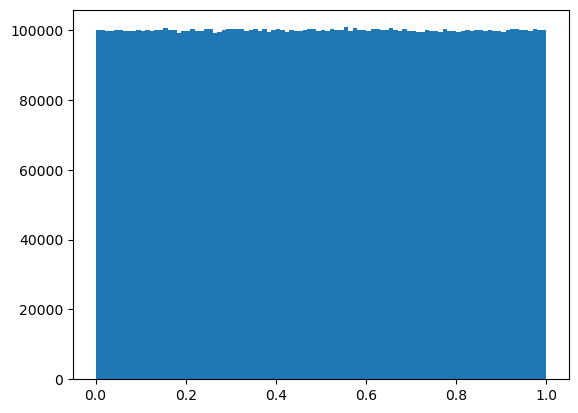

In [49]:
# we can verify that this is a uniform distribution
hist(df_test.first, 100);

So far all looks good. But let us look at the distribution of the last dawn random number:

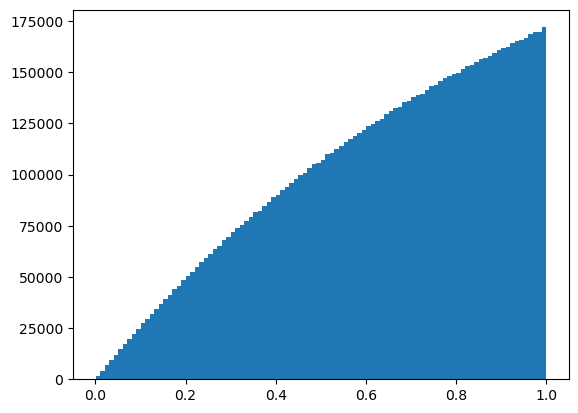

In [51]:
# the last drawn function shows that the histogram is not uniform anymore
hist(df_test.last, 100);

# why?
# the last value that I draw, will tend to be large to cross the cut-off
# if the number is very small, it is more likely that the process does not stop

So - is the `rand()` function broken for the last generated random number in each sequence or something else has made the distribution stop being uniform?